In [1]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import spacy
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
# Load the dataset
df = pd.read_csv('combined_dataset_training.csv', encoding='latin1')
print(df.head())

# Extract countries and policy descriptions
countries = df['country'].tolist()
documents = df['policy_description'].tolist()

# Combine countries and policy descriptions
combined_documents = [f"{country}: {policy}" for country, policy in zip(countries, documents)]

          country                                 policy_description
0          Norway  Fiscal compensation for the scrapping of fossi...
1  United Kingdom  The Northern Powerhouse Investment Fund (NPIF)...
2          Norway  The Norwegian Government Environmental Fund is...
3  United Kingdom  The Home Energy Scotland Advice Network consis...
4  United Kingdom                                        Legislative


In [4]:
# Preprocessing
nlp = spacy.load('en_core_web_sm')

# Preprocessing function
def preprocess_text(texts):
    preprocessed_texts = []
    for doc in texts:
        # Convert to lowercase
        doc = doc.lower()
        # Remove special characters and numbers
        doc = re.sub(r'\W+|\d+', ' ', doc)
        # Tokenize and lemmatize
        tokens = nlp(doc)
        lemmatized_tokens = [token.lemma_ for token in tokens if not token.is_stop and not token.is_punct and token.is_alpha]
        preprocessed_texts.append(lemmatized_tokens)
    return preprocessed_texts

preprocessed_docs = preprocess_text(combined_documents)
dictionary = corpora.Dictionary(preprocessed_docs)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

In [5]:
# Topic Modeling with LDA
num_topics = 2 # or try different values
passes = 20
iterations = 1000

lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, iterations=iterations)

In [6]:
# Calculate Perplexity
perplexity = lda_model.log_perplexity(corpus)
print(f"Perplexity: {perplexity}")

Perplexity: -5.449834770717392


In [7]:
# Calculate Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}")

Coherence Score: 0.4663088784633199


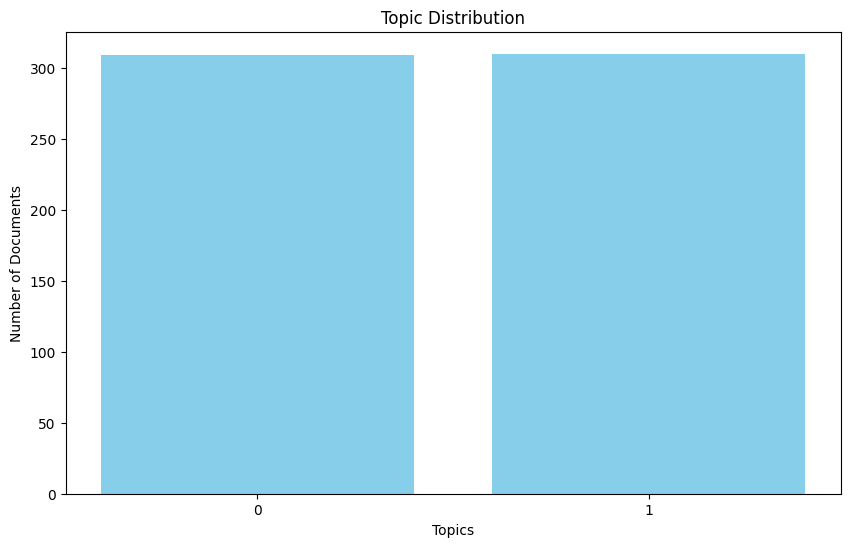

In [8]:
# Plot Topic Distribution
def plot_topic_distribution(model, corpus):
    topic_counts = [0] * model.num_topics
    for doc in corpus:
        topics = [topic for topic, _ in model.get_document_topics(doc)]
        for topic in topics:
            topic_counts[topic] += 1

    plt.figure(figsize=(10, 6))
    plt.bar(range(model.num_topics), topic_counts, color='skyblue')
    plt.xlabel('Topics')
    plt.ylabel('Number of Documents')
    plt.title('Topic Distribution')
    plt.xticks(range(model.num_topics))
    plt.show()

plot_topic_distribution(lda_model, corpus)

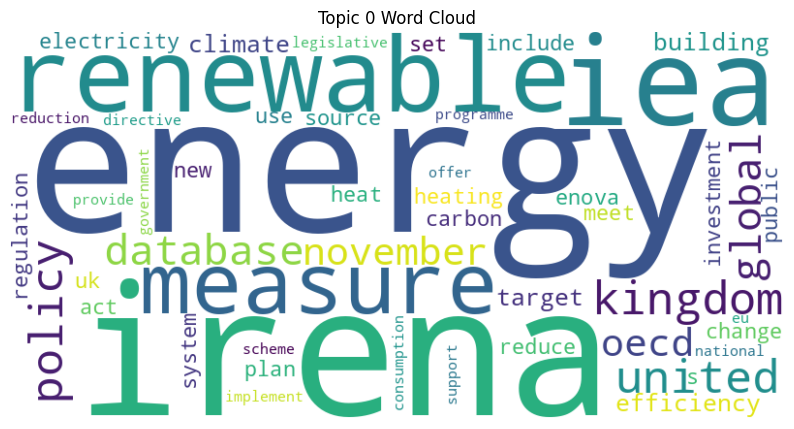

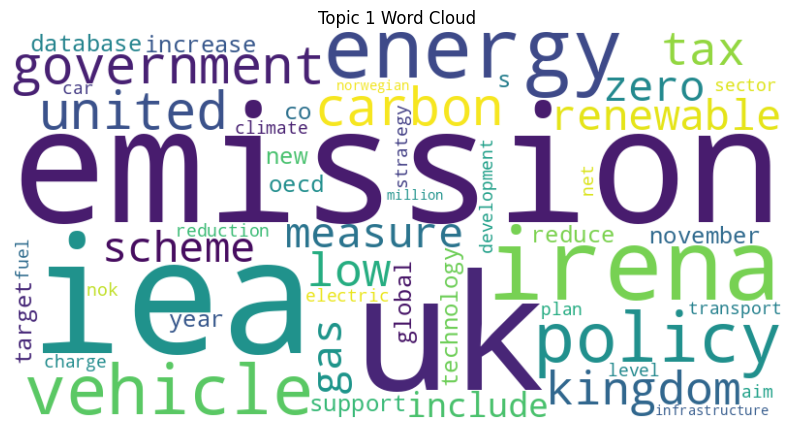

In [9]:
# Generate Word Clouds for each topic
def plot_word_cloud_for_topics(model, num_topics):
    for i in range(num_topics):
        plt.figure(figsize=(10, 6))
        words = ' '.join([word for word, _ in model.show_topic(i, topn=50)])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {i} Word Cloud')
        plt.show()

plot_word_cloud_for_topics(lda_model, num_topics)